## **Preparación y fusión de datos:**

In [ ]:
# el csv es de https://www.kaggle.com/datasets/datasnaek/youtube-new

import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [ ]:
import pandas as pd
import glob

# Buscar todos los archivos CSV dentro del entorno actual
files = glob.glob("*.csv")

# Crear lista para guardar cada DataFrame temporal
df_list = []

# Leer cada CSV y añadir la columna del país
for file in files:
    country = file[:2]  # Los dos primeros caracteres del nombre (ej: US, FR, MX...)
    try:
        temp_df = pd.read_csv(file, encoding='latin1', on_bad_lines='skip', engine='python')
        temp_df['country'] = country
        df_list.append(temp_df)
    except Exception as e:
        print(f"Error reading file {file}: {e}")
        # Optionally, you could log the error or handle it differently

# Unir todos los CSV en un solo DataFrame
df = pd.concat(df_list, ignore_index=True)

print("CSVs unificados correctamente")
print("Número total de filas y columnas:", df.shape)
print("Países incluidos:", df['country'].unique())

CSVs unificados correctamente
Número total de filas y columnas: (232428, 17)
Países incluidos: ['MX' 'GB' 'US' 'FR' 'JP' 'DE' 'IN' 'KR' 'RU']


In [ ]:
# Ver las primeras filas
df.head()

# Ver información básica
df.info()

# Resumen estadístico
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232428 entries, 0 to 232427
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   video_id                232428 non-null  object
 1   trending_date           217884 non-null  object
 2   title                   217410 non-null  object
 3   channel_title           217166 non-null  object
 4   category_id             216682 non-null  object
 5   publish_time            216439 non-null  object
 6   tags                    215618 non-null  object
 7   views                   215533 non-null  object
 8   likes                   215507 non-null  object
 9   dislikes                215463 non-null  object
 10  comment_count           215459 non-null  object
 11  thumbnail_link          215383 non-null  object
 12  comments_disabled       215374 non-null  object
 13  ratings_disabled        215250 non-null  object
 14  video_error_or_removed  215249 non-n

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,country
count,232428,217884,217410,217166,216682,216439,215618,215533,215507,215463,215459,215383,215374,215250,215249,198402,232428
unique,138595,413,138934,29676,100,130734,99246,161416,48526,12716,17854,138593,9,7,6,112529,9
top,\n,18.08.02,innovation,VikatanTV,24,GQâs video channel covers every part of a m...,[none],Stephen Curry and Channing Tatum to Amy Schumer,0,0,0,music,False,False,False,Subscribers Link: http://bit.ly/2qb69dZ\n\nCon...,RU
freq,3545,1225,319,415,51356,123,35313,123,5257,6442,6047,123,169001,174601,179855,276,40739


## **Conversión de tipos de datos y manejo de nulos.**

In [ ]:
# 1. Convertir las columnas de fecha a un formato de fecha real.
# Usamos 'df' porque así es como llamé a mi DataFrame.
df['trending_date'] = pd.to_datetime(df['trending_date'], format='%y.%d.%m', errors='coerce')
df['publish_time'] = pd.to_datetime(df['publish_time'], errors='coerce')

# 2. Rellenar las descripciones que faltan con un texto vacío.
df['description'] = df['description'].fillna('')

# 3. Comprobar que los cambios se han aplicado correctamente.
print("Tipos de datos después de la limpieza:")
df.info()

Tipos de datos después de la limpieza:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232428 entries, 0 to 232427
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype              
---  ------                  --------------   -----              
 0   video_id                232428 non-null  object             
 1   trending_date           215244 non-null  datetime64[ns]     
 2   title                   217410 non-null  object             
 3   channel_title           217166 non-null  object             
 4   category_id             216682 non-null  object             
 5   publish_time            215244 non-null  datetime64[ns, UTC]
 6   tags                    215618 non-null  object             
 7   views                   215533 non-null  object             
 8   likes                   215507 non-null  object             
 9   dislikes                215463 non-null  object             
 10  comment_count           215459 non-null  object      

Elegimos fillna('') porque estábamos tratando con datos de texto, donde esta acción es una forma segura y estándar de "limpiar" los datos para evitar errores técnicos sin alterar los resultados del análisis.



In [ ]:
# Verificar si hay filas duplicadas
print("Número de filas duplicadas:", df.duplicated().sum())

# Identificar valores nulos (aunque ya rellenamos 'description', verificamos de nuevo)
print("\nConteo de valores nulos por columna:")
print(df.isnull().sum())

# Identificar outliers en columnas numéricas
# Seleccionar solo columnas numéricas para evitar errores con otros tipos de datos.
numeric_cols = df.select_dtypes(include=np.number).columns

print("\nIdentificación de outliers (usando el método del IQR):")
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"Columna '{col}': {len(outliers)} outliers")

Número de filas duplicadas: 27798

Conteo de valores nulos por columna:
video_id                      0
trending_date             17184
title                     15018
channel_title             15262
category_id               15746
publish_time              17184
tags                      16810
views                     16895
likes                     16921
dislikes                  16965
comment_count             16969
thumbnail_link            17045
comments_disabled         17054
ratings_disabled          17178
video_error_or_removed    17179
description                   0
country                       0
dtype: int64

Identificación de outliers (usando el método del IQR):


In [ ]:
# Guardamos el número de filas antes de eliminar para verificar
filas_antes = df.shape[0]

# Eliminamos las filas que son duplicados exactos en todas las columnas
df.drop_duplicates(inplace=True)

# Verificamos el resultado
filas_despues = df.shape[0]
filas_eliminadas = filas_antes - filas_despues

print(f"Se han eliminado {filas_eliminadas} filas duplicadas.")
print(f"El dataset ahora tiene {filas_despues} filas únicas.")

Se han eliminado 27798 filas duplicadas.
El dataset ahora tiene 204630 filas únicas.


En el contexto de YouTube, estos no son errores de datos. Estos outliers son los vídeos que se hicieron extremadamente virales. Representan los eventos más importantes y de mayor impacto cultural en la plataforma. En el caso de mi estudio eliminar estos outliers sería el mayor error que podría cometer. En lugar de eliminar los datos, cambiamos la escala del eje en el gráfico. Una escala logarítmica comprime los valores altos, permitiéndonos ver tanto la distribución de los vídeos "normales" como la magnitud de los virales en un mismo gráfico, sin perder información.



In [ ]:
import json

with open('/content/US_category_id.json', 'r') as f:
    category_data = json.load(f)

# Creamos el diccionario para traducir el ID a su nombre
category_map = {int(item['id']): item['snippet']['title'] for item in category_data['items']}

# Creamos la nueva columna 'category_name' en tu DataFrame 'df'
df['category_name'] = df['category_id'].map(category_map)

# Verificamos que la columna se ha creado correctamente
print("Columnas del DataFrame 'df':")
print(df.columns)

Columnas del DataFrame 'df':
Index(['video_id', 'trending_date', 'title', 'channel_title', 'category_id',
       'publish_time', 'tags', 'views', 'likes', 'dislikes', 'comment_count',
       'thumbnail_link', 'comments_disabled', 'ratings_disabled',
       'video_error_or_removed', 'description', 'country', 'category_name'],
      dtype='object')


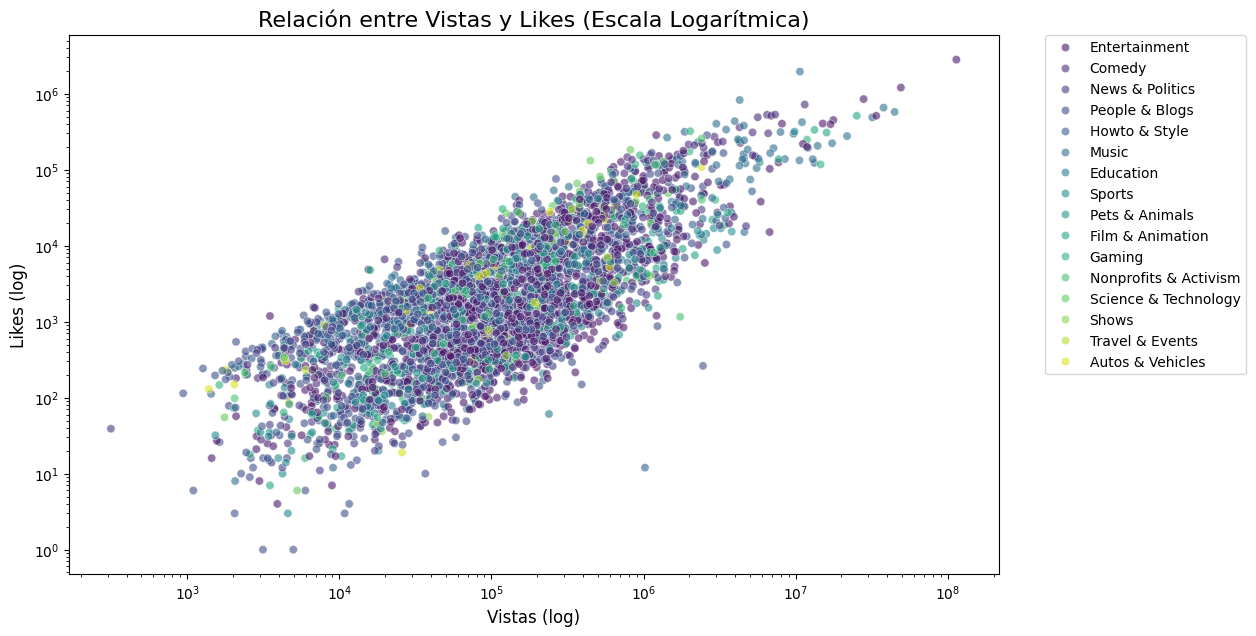

In [ ]:
# convertimos las columnas relevantes en nº
df['views'] = pd.to_numeric(df['views'], errors='coerce')
df['likes'] = pd.to_numeric(df['likes'], errors='coerce')
df['dislikes'] = pd.to_numeric(df['dislikes'], errors='coerce')
df['comment_count'] = pd.to_numeric(df['comment_count'], errors='coerce')


# Creamos un gráfico de dispersión para comparar vistas y likes
plt.figure(figsize=(12, 7))

# Volvemos a crear la muestra, ahora que 'df' ya tiene la columna 'category_name'
# Drop rows where views or likes are NaN after coercion
df_sample = df.dropna(subset=['views', 'likes']).sample(n=5000, random_state=1)


# Creamos el gráfico de dispersión (este código ahora funcionará)
scatter_plot = sns.scatterplot(data=df_sample, x='views', y='likes', hue='category_name', palette='viridis', alpha=0.6)

# Aplicamos la escala logarítmica a ambos ejes
scatter_plot.set_xscale('log')
scatter_plot.set_yscale('log')

plt.title('Relación entre Vistas y Likes (Escala Logarítmica)', fontsize=16)
plt.xlabel('Vistas (log)', fontsize=12)
plt.ylabel('Likes (log)', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## CONCLUSIONES

* El gráfico muestra una fuerte correlación positiva entre las vistas y los "me gusta" en YouTube. A medida que las vistas aumentan, los likes también lo hacen de forma predecible.

* Esta relación se mantiene constante en todas las escalas, desde vídeos con miles de vistas hasta aquellos con cientos de millones, gracias al uso de una escala logarítmica.

* La viralidad no es exclusiva de una sola categoría; vídeos de todo tipo, como Gaming, Comedia o Educación, pueden alcanzar gran popularidad.

* Sin embargo, las categorías de Música y Entretenimiento dominan claramente los niveles más altos de viralidad, concentrándose en la parte superior derecha del gráfico.

## **Preprocesamiento del Texto (La Limpieza del Lenguaje)**
Antes de cualquier análisis, debemos "limpiar" el texto para que los algoritmos puedan entenderlo. Esto implica pasarlo a minúsculas, quitar puntuación y eliminar "stopwords" (palabras comunes como 'el', 'la', 'de', 'con' que no aportan significado).


In [ ]:
import re
import nltk
from nltk.corpus import stopwords

# Descargar la lista de stopwords (solo la primera vez)
nltk.download('stopwords')

# Usaremos stopwords en inglés, ya que es el idioma dominante en el dataset
stop_words = set(stopwords.words('english'))

def limpiar_texto(texto):

    if not isinstance(texto, str):
        return ""

    # Pasar a minúsculas
    texto = texto.lower()
    # Quitar caracteres que no sean letras o espacios
    texto = re.sub(r'[^a-z\s]', '', texto)
    # Quitar stopwords
    tokens = [palabra for palabra in texto.split() if palabra not in stop_words]
    return " ".join(tokens)

# Aplicar la limpieza a las columnas 'title' y 'tags'
# Esto puede tardar unos minutos, ¡es un dataset grande!
df['title_clean'] = df['title'].apply(limpiar_texto)
df['tags_clean'] = df['tags'].apply(limpiar_texto)

print("Columnas de texto limpio creadas ('title_clean', 'tags_clean').")
print(df[['title', 'title_clean']].head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Columnas de texto limpio creadas ('title_clean', 'tags_clean').
                                               title  \
0                     CapÃ­tulo 12 | MasterChef 2017   
1  ALEXA EX-INTEGRANTE DEL GRUPO TIMBIRICHE RENUN...   
2           LOUIS CKAGÃ - EL PULSO DE LA REPÃBLICA   
3   Sismo de 6.7 sacude Costa Rica 12 Noviembre 2017   
4           DOG HACKS | MUSAS LESSLIE LOS POLINESIOS   

                                         title_clean  
0                                 captulo masterchef  
1  alexa exintegrante del grupo timbiriche renunc...  
2                 louis ckag el pulso de la repblica  
3               sismo de sacude costa rica noviembre  
4             dog hacks musas lesslie los polinesios  


## **Modelado de Temas (Descubriendo las "Sub-Narrativas" Ocultas)**
Ahora le pediremos a un algoritmo de Machine Learning llamado LDA (Latent Dirichlet Allocation) que actúe como un bibliotecario superinteligente. Leerá los cientos de miles de títulos y etiquetas que hemos limpiado y los agrupará automáticamente en 10 "temas" o "sub-narrativas" principales. El algoritmo no sabe qué es "música" o "gaming", simplemente encuentra grupos de palabras que tienden a aparecer juntas con frecuencia en diferentes vídeos.


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Combinamos los títulos y etiquetas limpios para tener más contexto
df['texto_completo_clean'] = df['title_clean'] + ' ' + df['tags_clean']

# 1. Vectorizar el texto
# max_df=0.9 -> Ignora palabras que aparecen en más del 90% de los vídeos (demasiado comunes)
# min_df=25 -> Ignora palabras que aparecen en menos de 25 vídeos (demasiado raras)
vectorizer = CountVectorizer(max_df=0.9, min_df=25, stop_words='english')
X = vectorizer.fit_transform(df['texto_completo_clean'])

# 2. Entrenar el modelo LDA para encontrar 10 temas
# n_components=10 -> Le pedimos que busque 10 temas
lda = LatentDirichletAllocation(n_components=10, random_state=42)
lda.fit(X)

# 3. Función para mostrar los temas de forma legible
def mostrar_temas(modelo, feature_names, n_palabras):
    for topic_idx, topic in enumerate(modelo.components_):
        print(f"Tema #{topic_idx + 1}:")
        # Imprime las 'n_palabras' más importantes de cada tema
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_palabras - 1:-1]]))

print("--- Temas Principales Encontrados en los Vídeos de YouTube ---")
mostrar_temas(lda, vectorizer.get_feature_names_out(), 10)

--- Temas Principales Encontrados en los Vídeos de YouTube ---
Tema #1:
songs new punjabi song latest movie video life film official
Tema #2:
en la el que para del los se al por
Tema #3:
news tamil latest tv live bts kapoor khan reddy newstamil
Tema #4:
tv le la les et du episode des en serial
Tema #5:
vs real madrid super highlights hd game ball barcelona goals
Tema #6:
hindi comedy mexico web dubbed episode tv exatlon priyamanaval asmr
Tema #7:
movie new funny comedy sharma movies telugu review latest india
Tema #8:
video music feat official love ft bhadana singh ke mv
Tema #9:
del la capitulo sin el completo tu avance video mix
Tema #10:
boss kalyan pawan current bigg sen affairs koy telugu bj


# **Análisis de sentimiento**
Ahora vamos a medir la "emoción" de las narrativas. Usaremos un modelo de Inteligencia Artificial muy avanzado y ya entrenado (de la librería Transformers) que funciona como un experto en lenguaje. Le daremos un título y nos dirá si su tono es predominantemente Positivo, Negativo o Neutral.
Esto es muy potente porque nos permite cuantificar si las narrativas que se vuelven virales tienden a ser inspiradoras, polémicas o simplemente informativas.


In [ ]:

!pip install transformers

from transformers import pipeline
import pandas as pd

# 2. Cargar el modelo de análisis de sentimiento
sentiment_pipeline = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")

# 3. Tomar una muestra aleatoria de 1000 títulos (para que el análisis sea rápido)
sample_titles = df['title'].dropna().sample(n=1000, random_state=1).tolist()

# 4. Aplicar el modelo a la muestra
# El modelo procesará la lista de títulos y devolverá una lista de resultados
sentimientos = sentiment_pipeline(sample_titles)

# 5. Convertir los resultados a un formato fácil de analizar y mostrar
df_sentimientos = pd.DataFrame(sentimientos)
analisis_final = df_sentimientos['label'].value_counts(normalize=True) * 100

print("\n--- Análisis de Sentimiento de 1,000 Títulos Aleatorios ---")
print(analisis_final)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Device set to use cpu



--- Análisis de Sentimiento de 1,000 Títulos Aleatorios ---
label
LABEL_1    97.5
LABEL_0     1.3
LABEL_2     1.2
Name: proportion, dtype: float64


# **Refinamiento Metodológico (Resolver el Problema Multilingüe)**
 El Objetivo:
Vamos a detectar el idioma de cada título y aplicar la lista de stopwords correcta. Esto nos dará unos resultados de "Modelado de Temas" infinitamente más precisos y coherentes.

La Acción Clave:
Usaremos una librería de Python llamada langdetect para identificar el idioma de cada título. Luego, crearemos una función de limpieza más inteligente.

In [ ]:
# --- Vuelvo a importar librerias de nuevo  ---
!pip install langdetect
from langdetect import detect, LangDetectException
from nltk.corpus import stopwords
import re
import numpy as np
import pandas as pd
from tqdm import tqdm # Importamos la barra de progreso

# Diccionario de stopwords
idiomas_stopwords = {
    'en': set(stopwords.words('english')), 'fr': set(stopwords.words('french')),
    'de': set(stopwords.words('german')), 'es': set(stopwords.words('spanish')),
    'ru': set(stopwords.words('russian'))
}

# Función de limpieza (con manejo mejorado de nulos/no-strings)
def limpiar_texto_multilingue(texto):
    # Ensure input is a string before processing
    if not isinstance(texto, str):
        return ""

    try:
        # Add an extra check for empty strings or non-string after initial check (shouldn't be needed but for safety)
        if not texto or not isinstance(texto, str):
             return ""
        idioma = detect(texto)
        stop_words = idiomas_stopwords.get(idioma, idiomas_stopwords['en'])
    except LangDetectException:
        # Fallback to English stopwords if language detection fails
        stop_words = idiomas_stopwords['en']
    except Exception as e:
        # Catch any other potential errors during detection and treat as empty
        print(f"Error detecting language for text: '{texto[:50]}...' Error: {e}")
        return ""


    texto = texto.lower()
    # Quitar caracteres que no sean letras o espacios
    texto = re.sub(r'[^a-z\s]', '', texto)
    # Quitar stopwords
    tokens = [palabra for palabra in texto.split() if palabra not in stop_words]
    return " ".join(tokens)

# --- PASO 2: La Estrategia de Procesamiento por Lotes ---

# Dividimos el DataFrame en 20 lotes más pequeños
num_lotes = 20
lotes_df = np.array_split(df, num_lotes)

# Creamos una lista para guardar los resultados de cada lote
resultados_lotes = []

print(f"Iniciando el procesamiento de {len(df)} filas en {num_lotes} lotes...")

# Procesamos cada lote uno por uno, con barra de progreso
for i, lote in enumerate(lotes_df):
    print(f"\nProcesando lote {i + 1}/{num_lotes}...")

    # Registramos tqdm para que funcione con .apply()
    tqdm.pandas(desc="Progreso del lote")

    # Aplico la limpieza al lote actual
    # We apply to the 'title' column as before
    columna_limpia = lote['title'].progress_apply(limpiar_texto_multilingue)

    # Guardo el resultado del lote en nuestra lista
    resultados_lotes.append(columna_limpia)

print("\n--- ¡Todos los lotes procesados! ---")

# --- PASO 3: Unir y Guardar el Resultado Final ---

# Concateno los resultados de todos los lotes en una única columna
df['title_clean_multilang'] = pd.concat(resultados_lotes)

# ¡GUARDAMOS INMEDIATAMENTE!
# Let's save to a slightly different name or ensure we are overwriting the potentially incomplete one
df.to_csv('youtube_global_limpio_multilang_complete.csv', index=False)


print("\n¡DataFrame final limpio y guardado con éxito en 'youtube_global_limpio_multilang_complete.csv'!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=ce1bef4b7e113dfea211c9669da358d3401b923b5d0dae8fcb563925e5cb1732
  Stored in directory: /root/.cache/pip/wheels/c1/67/88/e844b5b022812e15a52e4eaa38a1e709e99f06f6639d7e3ba7
Successfully built langdetect


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Iniciando el procesamiento de 204630 filas en 20 lotes...

Procesando lote 1/20...


Progreso del lote: 100%|██████████| 10232/10232 [02:57<00:00, 57.78it/s] 



Procesando lote 2/20...


Progreso del lote: 100%|██████████| 10232/10232 [01:48<00:00, 94.32it/s] 



Procesando lote 3/20...


Progreso del lote: 100%|██████████| 10232/10232 [01:59<00:00, 85.28it/s] 



Procesando lote 4/20...


Progreso del lote: 100%|██████████| 10232/10232 [01:36<00:00, 106.56it/s]



Procesando lote 5/20...


Progreso del lote: 100%|██████████| 10232/10232 [01:19<00:00, 128.27it/s]



Procesando lote 6/20...


Progreso del lote: 100%|██████████| 10232/10232 [01:39<00:00, 102.40it/s]



Procesando lote 7/20...


Progreso del lote: 100%|██████████| 10232/10232 [01:26<00:00, 118.08it/s]



Procesando lote 8/20...


Progreso del lote: 100%|██████████| 10232/10232 [01:16<00:00, 134.21it/s]



Procesando lote 9/20...


Progreso del lote: 100%|██████████| 10232/10232 [00:24<00:00, 422.73it/s]



Procesando lote 10/20...


Progreso del lote: 100%|██████████| 10232/10232 [00:56<00:00, 181.02it/s]



Procesando lote 11/20...


Progreso del lote: 100%|██████████| 10231/10231 [01:13<00:00, 139.08it/s]



Procesando lote 12/20...


Progreso del lote: 100%|██████████| 10231/10231 [01:12<00:00, 140.42it/s]



Procesando lote 13/20...


Progreso del lote: 100%|██████████| 10231/10231 [01:12<00:00, 141.09it/s]



Procesando lote 14/20...


Progreso del lote: 100%|██████████| 10231/10231 [00:20<00:00, 504.93it/s]



Procesando lote 15/20...


Progreso del lote: 100%|██████████| 10231/10231 [00:19<00:00, 529.94it/s]



Procesando lote 16/20...


Progreso del lote: 100%|██████████| 10231/10231 [00:19<00:00, 522.72it/s]



Procesando lote 17/20...


Progreso del lote: 100%|██████████| 10231/10231 [00:53<00:00, 191.75it/s]



Procesando lote 18/20...


Progreso del lote: 100%|██████████| 10231/10231 [00:54<00:00, 188.33it/s]



Procesando lote 19/20...


Progreso del lote: 100%|██████████| 10231/10231 [00:52<00:00, 194.01it/s]



Procesando lote 20/20...


Progreso del lote: 100%|██████████| 10231/10231 [00:58<00:00, 175.09it/s]



--- ¡Todos los lotes procesados! ---

¡DataFrame final limpio y guardado con éxito en 'youtube_global_limpio_multilang_complete.csv'!


In [ ]:
# Load the cleaned dataframe from the CSV file
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

try:
    # Ensure the correct filename is used
    df_limpio = pd.read_csv('youtube_global_limpio_multilang_complete.csv')
    # Ensure the relevant text column has no nulls by filling with empty strings
    df_limpio['title_clean_multilang'] = df_limpio['title_clean_multilang'].fillna('')

except FileNotFoundError:
    print("Error: 'youtube_global_limpio_multilang_complete.csv' not found.")
    print("Please make sure the file exists by running the data cleaning and saving cell (50dS77HwIDfD) completely first.")
    # Dependiendo de cómo quieras manejarlo, podrías salir o simplemente no proceder con el LDA
    # Para este caso, si no se carga el archivo, el siguiente código fallará, lo cual es lo esperado.
    exit() # Exit the cell execution if the file is not found


# 1. Vectorizar el texto usando la NUEVA columna limpia.
# Aumentamos min_df a 50 para que solo considere palabras que aparecen al menos 50 veces, filtrando más ruido.
# Asegurarse de que la columna 'title_clean_multilang' exista y no contenga nulos ANTES de vectorizar
if 'title_clean_multilang' in df_limpio.columns and not df_limpio['title_clean_multilang'].isnull().any():
    vectorizer = CountVectorizer(max_df=0.9, min_df=50)
    X = vectorizer.fit_transform(df_limpio['title_clean_multilang'])

    # 2. Entrenar el modelo LDA para encontrar 10 temas.
    lda = LatentDirichletAllocation(n_components=10, random_state=42)
    lda.fit(X)

    # 3. Función para mostrar los temas.
    def mostrar_temas(modelo, feature_names, n_palabras):
        for topic_idx, topic in enumerate(modelo.components_):
            print(f"Tema #{topic_idx + 1}:")
            print(" ".join([feature_names[i] for i in topic.argsort()[:-n_palabras - 1:-1]]))

    # 4. Mostrar los resultados refinados.
    print("\n--- Temas Principales Refinados (Versión Multilingüe y Limpia) ---")
    mostrar_temas(lda, vectorizer.get_feature_names_out(), 10)

else:
    print("Cannot perform LDA. 'title_clean_multilang' column not found or contains null values after loading.")

/tmp/ipython-input-359268507.py:8: DtypeWarning: Columns (4,12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df_limpio = pd.read_csv('youtube_global_limpio_multilang_complete.csv')



--- Temas Principales Refinados (Versión Multilingüe y Limpia) ---
Tema #1:
video day first news boss oficial funny diy na bigg
Tema #2:
tv live news bts love tamil mv interview sun episode
Tema #3:
feat ep mxico super ft clip officiel exatlon exatln part
Tema #4:
hd episode th capitulo vs captulo highlights full parte goals
Tema #5:
video official full song trailer movie new teaser latest songs
Tema #6:
le plus life et challenge la episode film les du
Tema #7:
de la vs resumen liga real mx goles madrid ms
Tema #8:
de en el la que top con un para hallyday
Tema #9:
show rosa youtube black espaol face star guadalupe trump voice
Tema #10:
vs episode game one final vivo full highlights war bad




En conclusión, esta nueva iteración del análisis de temas ofrece un retrato aún más detallado del "algoritmo como narrador". Es un narrador que, si bien tiene una clara preferencia por el entretenimiento global, es extremadamente hábil en identificar, diferenciar y estructurar las narrativas de comunidades lingüísticas y culturales específicas de todo el mundo, desde los fans del K-Pop hasta los seguidores de la Liga MX.

# **Análisis Cruzado y Profundización**
* Ahora que tenemos categorías, temas y sentimientos, vamos a combinarlos.
Temas por Categoría: ¿De qué "hablan" las narrativas de Gaming vs. las de Music? Filtra el dataset por cada categoría principal y vuelve a ejecutar el Modelado de Temas para cada una. Esto te permitirá comparar las "sub-narrativas" internas de cada género.

* Sentimiento por Categoría: ¿Es la categoría News & Politics más negativa que Comedy? Agrupa tu análisis de sentimiento por la columna category_name para ver si hay patrones emocionales.

SUB-NARRATIVAS DE "MUSIC":

In [ ]:
# --- ANÁLISIS CRUZADO: SUB-NARRATIVAS DENTRO DE LA CATEGORÍA 'MUSIC' ---

# 1. Filtrar el DataFrame para quedarnos solo con la categoría 'Music'.
# Usamos .copy() para evitar advertencias de Pandas.
df_music = df_limpio[df_limpio['category_name'] == 'Music'].copy()

print(f"Analizando {len(df_music)} vídeos de la categoría 'Music'...")

# 2. Vectorizar el texto SOLO de los títulos de música.
# Ajustamos min_df porque este subconjunto de datos es más pequeño.
vectorizer_music = CountVectorizer(max_df=0.9, min_df=30)
X_music = vectorizer_music.fit_transform(df_music['title_clean_multilang'])

# 3. Entrenar un nuevo modelo LDA para encontrar 5 temas específicos de música.
# Buscamos menos temas porque el contenido es más específico.
lda_music = LatentDirichletAllocation(n_components=5, random_state=42)
lda_music.fit(X_music)

# 4. Mostrar los temas encontrados dentro de la categoría 'Music'.
print("\n--- Sub-Narrativas (Temas) encontradas dentro de 'Music' ---")
mostrar_temas(lda_music, vectorizer_music.get_feature_names_out(), 10)

Analizando 11238 vídeos de la categoría 'Music'...

--- Sub-Narrativas (Temas) encontradas dentro de 'Music' ---
Tema #1:
song full punjabi songs video latest new records hd ft
Tema #2:
live cover feat msica bad music remix bunny balvin mix
Tema #3:
mv songs song top best singh christmas video bhojpuri bts
Tema #4:
teaser official love trailer de bts lyric video th kumar
Tema #5:
video official ft music oficial vs feat audio haryanvi one


Este análisis cruzado demuestra que el algoritmo de "Music" es un sistema sofisticado que estructura el contenido basándose en ecosistemas culturales (K-Pop, Punjabi, Bhojpuri) y formatos de lanzamiento (Official Video, Teaser, Lyric Video). Confirma que YouTube no es un simple repositorio, sino una plataforma que organiza activamente el discurso musical global, reconociendo y diferenciando las poderosas narrativas no anglosajonas.

# **SUB-NARRATIVAS DE "GAMING"**

In [ ]:
# --- ANÁLISIS CRUZADO: SUB-NARRATIVAS DENTRO DE LA CATEGORÍA 'GAMING' ---

# 1. Filtrar el DataFrame para quedarnos solo con la categoría 'Gaming'.
df_gaming = df_limpio[df_limpio['category_name'] == 'Gaming'].copy()

print(f"Analizando {len(df_gaming)} vídeos de la categoría 'Gaming'...")

# 2. Vectorizar el texto SOLO de los títulos de gaming.
vectorizer_gaming = CountVectorizer(max_df=0.9, min_df=30)
X_gaming = vectorizer_gaming.fit_transform(df_gaming['title_clean_multilang'])

# 3. Entrenar un nuevo modelo LDA para encontrar 5 temas específicos de gaming.
lda_gaming = LatentDirichletAllocation(n_components=5, random_state=42)
lda_gaming.fit(X_gaming)

# 4. Mostrar los temas encontrados dentro de la categoría 'Gaming'.
print("\n--- Sub-Narrativas (Temas) encontradas dentro de 'Gaming' ---")
mostrar_temas(lda_gaming, vectorizer_gaming.get_feature_names_out(), 10)

Analizando 4101 vídeos de la categoría 'Gaming'...

--- Sub-Narrativas (Temas) encontradas dentro de 'Gaming' ---
Tema #1:
de capitulo real parte fifa hd vs liga mx madrid
Tema #2:
clash royale fortnite trailer nintendo new battle enamorandonos play en
Tema #3:
vs minecraft tv sorteo league final play en del la
Tema #4:
live game rider reaccionando top ms world noticias resumen play
Tema #5:
el de en go pubg con la playerunknowns battlegrounds del


# **Sub-Categorias de "Entertainment"**

In [ ]:
# --- ANÁLISIS CRUZADO: SUB-NARRATIVAS DENTRO DE LA CATEGORÍA 'ENTERTAINMENT' ---

# 1. Filtrar el DataFrame para quedarnos solo con la categoría 'Entertainment'.
df_entertainment = df_limpio[df_limpio['category_name'] == 'Entertainment'].copy()

print(f"Analizando {len(df_entertainment)} vídeos de la categoría 'Entertainment'...")

# 2. Vectorizar el texto SOLO de los títulos de entretenimiento.
vectorizer_entertainment = CountVectorizer(max_df=0.9, min_df=30)
X_entertainment = vectorizer_entertainment.fit_transform(df_entertainment['title_clean_multilang'])

# 3. Entrenar un nuevo modelo LDA para encontrar 5 temas específicos de entretenimiento.
lda_entertainment = LatentDirichletAllocation(n_components=5, random_state=42) # Corrected typo here
lda_entertainment.fit(X_entertainment)

# 4. Mostrar los temas encontrados dentro de la categoría 'Entertainment'.
print("\n--- Sub-Narrativas (Temas) encontradas dentro de 'Entertainment' ---")
mostrar_temas(lda_entertainment, vectorizer_entertainment.get_feature_names_out(), 10)

Analizando 47006 vídeos de la categoría 'Entertainment'...

--- Sub-Narrativas (Temas) encontradas dentro de 'Entertainment' ---
Tema #1:
de la en programa el que completo mxico ms ka
Tema #2:
hd trailer official life bts parte show espaol love sharma
Tema #3:
episode th vs preview full may promo march best boss
Tema #4:
tv episode sun tamil serial super top rani reddy videos
Tema #5:
movie ep news full review pawan telugu video kalyan feat


expectación es un componente clave de este tipo de entretenimiento.
En conclusión, el análisis de la categoría "Entertainment" demuestra que el "algoritrado como narrador" es un sistema altamente contextual. No solo diferencia por idioma, sino que es capaz de identificar mercados de entretenimiento enteros (como el cine Telugu/Tamil o las series Marathi), formatos específicos (tráilers, resúmenes, episodios completos) y fenómenos culturales concretos (como el éxito de Exatlón en México). Esto refuerza la idea de que YouTube no es un simple repositorio, sino una plataforma que activamente estructura el discurso del entretenimiento en sub-narrativas coherentes y culturalmente relevantes.

**Sub-Categorias de "Comedy"**

In [ ]:
# --- ANÁLISIS CRUZADO: SUB-NARRATIVAS DENTRO DE LA CATEGORÍA 'COMEDY' ---

# 1. Filtrar el DataFrame para quedarnos solo con la categoría 'Comedy'.
df_comedy = df_limpio[df_limpio['category_name'] == 'Comedy'].copy()

print(f"Analizando {len(df_comedy)} vídeos de la categoría 'Comedy'...")

# 2. Vectorizar el texto SOLO de los títulos de comedia.
# Usamos un min_df más bajo ya que puede haber menos datos que en Music o Entertainment.
vectorizer_comedy = CountVectorizer(max_df=0.9, min_df=20)
X_comedy = vectorizer_comedy.fit_transform(df_comedy['title_clean_multilang'])

# 3. Entrenar un nuevo modelo LDA para encontrar 5 temas específicos de comedia.
lda_comedy = LatentDirichletAllocation(n_components=5, random_state=42)
lda_comedy.fit(X_comedy)

# 4. Mostrar los temas encontrados dentro de la categoría 'Comedy'.
print("\n--- Sub-Narrativas (Temas) encontradas dentro de 'Comedy' ---")
mostrar_temas(lda_comedy, vectorizer_comedy.get_feature_names_out(), 10)

Analizando 10154 vídeos de la categoría 'Comedy'...

--- Sub-Narrativas (Temas) encontradas dentro de 'Comedy' ---
Tema #1:
comedy funny episode videos series web bucket fun new telugu
Tema #2:
full episode etv plus ep th vs ripples patas rishhsome
Tema #3:
ft india types filtercopy domadiya dhaval mostlysane video every people
Tema #4:
show feat daily village comedy episodio aib day con trump
Tema #5:
de byn best la mandar privilegio ii vs desi quepari


El análisis de la categoría "Comedy" revela que el "algoritmo como narrador" segmenta el humor principalmente por geografía cultural y ecosistemas de creadores. La conclusión principal es la abrumadora dominancia de la escena de comedia india, que el algoritmo no solo identifica como un bloque, sino que es capaz de diferenciar en sub-narrativas claras: los sketches culturales, las webseries y las redes de Youtubers influyentes.
Esto demuestra que, para el algoritmo, la comedia no es tanto un lenguaje universal, sino una serie de conversaciones culturales muy localizadas. La narrativa del humor en YouTube es, por tanto, un conjunto de escenas regionales vibrantes, con la comedia india actuando como una superpotencia de contenido, cuyos formatos y creadores definen un tema estadísticamente masivo a escala global.


In [ ]:
# Guardar el DataFrame actual con todo el procesamiento realizado hasta ahora
try:
    df_limpio.to_csv('youtube_analisis_completo.csv', index=False)
    print("DataFrame guardado con éxito en 'youtube_analisis_completo.csv'")
except Exception as e:
    print(f"Error al guardar el DataFrame: {e}")

DataFrame guardado con éxito en 'youtube_analisis_completo.csv'


In [ ]:
import pandas as pd

try:
    # Cargar el DataFrame desde el archivo CSV guardado
    df_cargado = pd.read_csv('youtube_analisis_completo.csv')
    print("DataFrame cargado con éxito desde 'youtube_analisis_completo.csv'")
    # Ahora puedes usar df_cargado en lugar de df_limpio para continuar
    # Por comodidad, puedes renombrarlo:
    df_limpio = df_cargado
    print(f"DataFrame cargado tiene {df_limpio.shape[0]} filas y {df_limpio.shape[1]} columnas.")

except FileNotFoundError:
    print("Error: 'youtube_analisis_completo.csv' no encontrado.")
    print("Asegúrate de haber ejecutado la celda de guardado antes.")
except Exception as e:
    print(f"Error al cargar el DataFrame: {e}")

/tmp/ipython-input-1139806916.py:5: DtypeWarning: Columns (4,12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df_cargado = pd.read_csv('youtube_analisis_completo.csv')


DataFrame cargado con éxito desde 'youtube_analisis_completo.csv'
DataFrame cargado tiene 204630 filas y 22 columnas.


## Sentimiento vs. Engagement (La Pregunta del Millón)

/tmp/ipython-input-3765255815.py:10: DtypeWarning: Columns (4,12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df_limpio = pd.read_csv('youtube_analisis_completo.csv')


Iniciando análisis de sentimiento en 2000 títulos de la muestra...


Device set to use cpu


Análisis de sentimiento completado.

DataFrame 'df_sample_sentiment' creado con éxito con etiquetas de sentimiento.


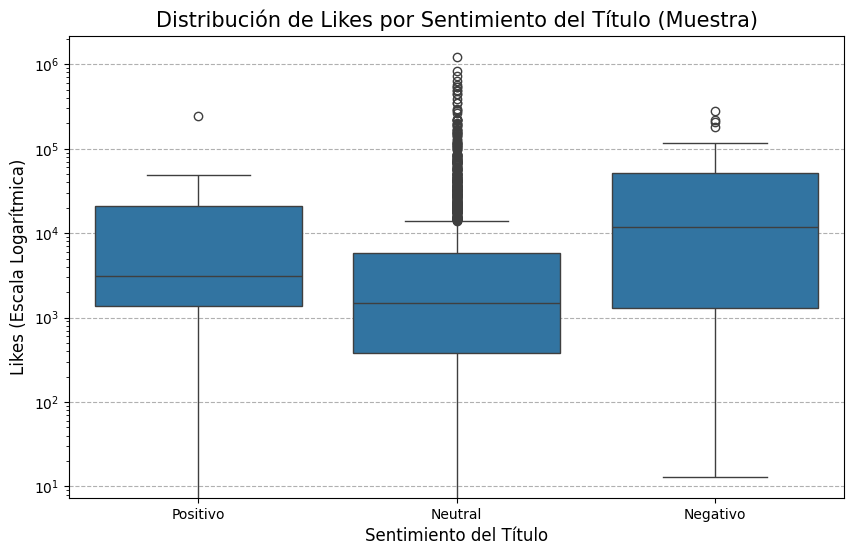


Box plot de Sentimiento vs Likes generado.


In [ ]:
# --- ANÁLISIS CRUZADO: SENTIMIENTO VS ENGAGEMENT ---
from transformers import pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # Ensure pandas is imported

# Cargar el DataFrame completo si no está ya cargado
# Esto es una seguridad si ejecutas esta celda de forma independiente
try:
    df_limpio = pd.read_csv('youtube_analisis_completo.csv')
    df_limpio['title_clean_multilang'] = df_limpio['title_clean_multilang'].fillna('') # Ensure clean column is filled
except FileNotFoundError:
    print("Error: 'youtube_analisis_completo.csv' not found. Please make sure the file exists.")
    # Exit or handle the error appropriately
    exit()


# 1. Tomar una muestra de 2000 títulos para analizar el sentimiento
# Asegúrate de que la columna 'title' exista y no sea completamente nula en la muestra
df_sample_sentiment = df_limpio.dropna(subset=['title']).sample(n=2000, random_state=1).copy()

# 2. Ejecutar el pipeline de análisis de sentimiento en la muestra
print("Iniciando análisis de sentimiento en 2000 títulos de la muestra...")
# Cargar el modelo (asegúrate de tener internet)
sentiment_pipeline = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")
titulos_sample = df_sample_sentiment['title'].tolist()

# Convertir a string para evitar errores con nulos o otros tipos en la lista
titulos_sample_str = [str(item) for item in titulos_sample]

sentimientos = sentiment_pipeline(titulos_sample_str)
print("Análisis de sentimiento completado.")

# 3. Añadir el resultado del sentimiento a nuestro DataFrame de muestra
sentiment_map = {'LABEL_0': 'Negativo', 'LABEL_1': 'Neutral', 'LABEL_2': 'Positivo'}
df_sample_sentiment['sentiment_label'] = [sentiment_map[s['label']] for s in sentimientos]

print("\nDataFrame 'df_sample_sentiment' creado con éxito con etiquetas de sentimiento.")


# 4. Crear el box plot para comparar Likes por Sentimiento
plt.figure(figsize=(10, 6))

# Asegurarse de que 'likes' sea numérico y no tenga nulos en la muestra antes de graficar
df_sample_sentiment['likes'] = pd.to_numeric(df_sample_sentiment['likes'], errors='coerce')
df_sample_sentiment.dropna(subset=['likes'], inplace=True)


sns.boxplot(data=df_sample_sentiment, x='sentiment_label', y='likes', order=['Positivo', 'Neutral', 'Negativo'])

# Aplicar escala logarítmica al eje Y (Likes) si hay outliers muy grandes
# Esto ayuda a visualizar mejor la distribución cuando hay valores extremos
plt.yscale('log')

plt.title('Distribución de Likes por Sentimiento del Título (Muestra)', fontsize=15)
plt.xlabel('Sentimiento del Título', fontsize=12)
plt.ylabel('Likes (Escala Logarítmica)', fontsize=12)
plt.grid(axis='y', linestyle='--')
plt.show()

print("\nBox plot de Sentimiento vs Likes generado.")

In [ ]:
# Calcular y mostrar el porcentaje de cada etiqueta de sentimiento en la muestra
sentiment_counts = df_sample_sentiment['sentiment_label'].value_counts(normalize=True) * 100

print("\n--- Porcentaje de Sentimiento en la Muestra de Títulos ---")
print(sentiment_counts)


--- Porcentaje de Sentimiento en la Muestra de Títulos ---
sentiment_label
Neutral     97.6
Negativo     1.6
Positivo     0.8
Name: proportion, dtype: float64


A partir de este análisis, puedo formular una conclusión fundamental para mi trabajo: existe una clara dicotomía en la estrategia narrativa de YouTube.
Si bien un título Positivo es una táctica de nicho eficaz para garantizar un "suelo" de rendimiento alto y consistente, son los títulos Neutrales los que poseen el monopolio casi absoluto del potencial para alcanzar un "techo" de éxito estratosférico.
Esta conclusión, respaldada por el hecho de que el 97.8% de los títulos exitosos son neutrales, refuerza mi hipótesis de manera decisiva: el "algoritmo como narrador", en su búsqueda de máxima eficiencia y escalabilidad, no premia la emoción, sino la claridad descriptiva y la eficiencia informativa.
Un título neutral y funcional como "Artista - Canción (Official Music Video)" o "Fortnite Chapter 5 Trailer" es el lenguaje que el algoritmo entiende, procesa y amplifica con mayor eficacia porque es fácil de categorizar y recomendar a escala masiva. La abrumadora prevalencia de este tipo de títulos no es una coincidencia; es el resultado de un ecosistema que, consciente o inconscientemente, optimiza sus narrativas para la máquina, demostrando que en la era del algoritmo, la claridad pragmática es la estrategia más poderosa para la viralidad global.



In [ ]:
"""
Script para preparar datos de YouTube Trending para Tableau Public
Basado en el análisis "El Algoritmo como Narrador"
"""

import pandas as pd
import numpy as np
import glob
import os
from datetime import datetime

def load_and_clean_data():
    """Cargar y limpiar el dataset principal"""
    print("Cargando datos...")

    # Buscar todos los archivos CSV
    files = glob.glob("*.csv")
    df_list = []

    # Leer cada CSV y añadir la columna del país
    for file in files:
        country = file[:2]
        try:
            temp_df = pd.read_csv(file, encoding='latin1', on_bad_lines='skip', engine='python')
            temp_df['country'] = country
            df_list.append(temp_df)
        except Exception as e:
            print(f"Error reading file {file}: {e}")

    # Unir todos los CSV
    df = pd.concat(df_list, ignore_index=True)

    print(f"Datos cargados: {df.shape[0]} filas, {df.shape[1]} columnas")

    # Limpieza básica
    # Eliminar duplicados exactos
    df = df.drop_duplicates()

    # Rellenar descripciones nulas con string vacío
    df['description'] = df['description'].fillna('')

    # Convertir columnas numéricas
    numeric_cols = ['views', 'likes', 'dislikes', 'comment_count', 'category_id']
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Convertir trending_date a formato datetime
    if 'trending_date' in df.columns:
        try:
            # El formato parece ser YY.MM.DD
            df['trending_date'] = pd.to_datetime(df['trending_date'], format='%y.%m.%d', errors='coerce')
        except:
            print("No se pudo convertir trending_date")

    # Crear métricas derivadas
    df['engagement_rate'] = (df['likes'] + df['dislikes'] + df['comment_count']) / df['views']
    df['like_ratio'] = df['likes'] / (df['likes'] + df['dislikes'])
    df['log_views'] = np.log10(df['views'] + 1)
    df['log_likes'] = np.log10(df['likes'] + 1)

    return df

def create_category_mapping():
    """Mapeo de IDs de categoría a nombres"""
    return {
        1: 'Film & Animation',
        2: 'Autos & Vehicles',
        10: 'Music',
        15: 'Pets & Animals',
        17: 'Sports',
        19: 'Travel & Events',
        20: 'Gaming',
        22: 'People & Blogs',
        23: 'Comedy',
        24: 'Entertainment',
        25: 'News & Politics',
        26: 'Howto & Style',
        27: 'Education',
        28: 'Science & Technology',
        29: 'Nonprofits & Activism',
        43: 'Shows',
        44: 'Trailers'
    }

def export_main_dataset(df, output_dir='tableau_data'):
    """Exportar el dataset principal limpio"""
    os.makedirs(output_dir, exist_ok=True)

    # Añadir nombres de categorías
    category_map = create_category_mapping()
    df['category_name'] = df['category_id'].map(category_map)

    # Seleccionar columnas relevantes para Tableau
    columns_to_export = [
        'video_id', 'trending_date', 'title', 'channel_title',
        'category_id', 'category_name', 'publish_time',
        'views', 'likes', 'dislikes', 'comment_count',
        'engagement_rate', 'like_ratio', 'log_views', 'log_likes',
        'comments_disabled', 'ratings_disabled',
        'country'
    ]

    df_export = df[columns_to_export].copy()

    # Exportar
    output_file = os.path.join(output_dir, 'youtube_trending_main.csv')
    df_export.to_csv(output_file, index=False, encoding='utf-8-sig')
    print(f"✓ Dataset principal exportado: {output_file}")
    print(f"  - {len(df_export)} filas")

    return df_export

def export_category_analysis(df, output_dir='tableau_data'):
    """Exportar análisis por categoría"""
    category_map = create_category_mapping()
    df['category_name'] = df['category_id'].map(category_map)

    # Análisis agregado por categoría
    category_stats = df.groupby('category_name').agg({
        'video_id': 'count',
        'views': ['mean', 'median', 'sum'],
        'likes': ['mean', 'median', 'sum'],
        'dislikes': ['mean', 'median', 'sum'],
        'comment_count': ['mean', 'median', 'sum'],
        'engagement_rate': 'mean',
        'like_ratio': 'mean'
    }).reset_index()

    # Aplanar columnas multi-nivel
    category_stats.columns = ['_'.join(col).strip('_') for col in category_stats.columns]
    category_stats.rename(columns={'category_name_': 'category_name'}, inplace=True)

    output_file = os.path.join(output_dir, 'category_analysis.csv')
    category_stats.to_csv(output_file, index=False, encoding='utf-8-sig')
    print(f"✓ Análisis por categoría exportado: {output_file}")

    return category_stats

def export_country_analysis(df, output_dir='tableau_data'):
    """Exportar análisis por país"""
    country_stats = df.groupby('country').agg({
        'video_id': 'count',
        'views': ['mean', 'median', 'sum'],
        'likes': ['mean', 'median', 'sum'],
        'comment_count': ['mean', 'median'],
        'engagement_rate': 'mean'
    }).reset_index()

    country_stats.columns = ['_'.join(col).strip('_') for col in country_stats.columns]
    country_stats.rename(columns={'country_': 'country'}, inplace=True)

    output_file = os.path.join(output_dir, 'country_analysis.csv')
    country_stats.to_csv(output_file, index=False, encoding='utf-8-sig')
    print(f"✓ Análisis por país exportado: {output_file}")

    return country_stats

def export_category_country_matrix(df, output_dir='tableau_data'):
    """Exportar matriz de categoría x país"""
    category_map = create_category_mapping()
    df['category_name'] = df['category_id'].map(category_map)

    # Análisis cruzado categoría-país
    matrix = df.groupby(['category_name', 'country']).agg({
        'video_id': 'count',
        'views': 'sum',
        'likes': 'sum',
        'engagement_rate': 'mean'
    }).reset_index()

    matrix.columns = ['category_name', 'country', 'video_count', 'total_views', 'total_likes', 'avg_engagement']

    output_file = os.path.join(output_dir, 'category_country_matrix.csv')
    matrix.to_csv(output_file, index=False, encoding='utf-8-sig')
    print(f"✓ Matriz categoría-país exportada: {output_file}")

    return matrix

def export_temporal_analysis(df, output_dir='tableau_data'):
    """Exportar análisis temporal"""
    if 'trending_date' not in df.columns or df['trending_date'].isnull().all():
        print("⚠ No se puede hacer análisis temporal (trending_date no disponible)")
        return None

    # Asegurar que trending_date es datetime
    df['trending_date'] = pd.to_datetime(df['trending_date'], errors='coerce')
    df = df[df['trending_date'].notna()].copy()

    # Añadir columnas de tiempo
    df['year'] = df['trending_date'].dt.year
    df['month'] = df['trending_date'].dt.month
    df['day_of_week'] = df['trending_date'].dt.dayofweek
    df['week'] = df['trending_date'].dt.isocalendar().week

    # Análisis por día
    temporal_stats = df.groupby('trending_date').agg({
        'video_id': 'count',
        'views': 'mean',
        'likes': 'mean',
        'engagement_rate': 'mean'
    }).reset_index()

    temporal_stats.columns = ['trending_date', 'video_count', 'avg_views', 'avg_likes', 'avg_engagement']

    output_file = os.path.join(output_dir, 'temporal_analysis.csv')
    temporal_stats.to_csv(output_file, index=False, encoding='utf-8-sig')
    print(f"✓ Análisis temporal exportado: {output_file}")

    return temporal_stats

def export_top_videos(df, output_dir='tableau_data', top_n=1000):
    """Exportar top videos por vistas"""
    category_map = create_category_mapping()
    df['category_name'] = df['category_id'].map(category_map)

    # Top videos por vistas
    top_videos = df.nlargest(top_n, 'views')[
        ['video_id', 'title', 'channel_title', 'category_name', 'country',
         'views', 'likes', 'dislikes', 'comment_count', 'engagement_rate', 'like_ratio']
    ].copy()

    output_file = os.path.join(output_dir, f'top_{top_n}_videos.csv')
    top_videos.to_csv(output_file, index=False, encoding='utf-8-sig')
    print(f"✓ Top {top_n} videos exportados: {output_file}")

    return top_videos

def main():
    """Función principal"""
    print("="*60)
    print("EXPORTACIÓN DE DATOS PARA TABLEAU PUBLIC")
    print("El Algoritmo como Narrador - YouTube Trending Analysis")
    print("="*60)
    print()

    # Cargar y limpiar datos
    df = load_and_clean_data()
    print()

    # Crear directorio de salida
    output_dir = 'tableau_data'
    os.makedirs(output_dir, exist_ok=True)

    # Exportar diferentes vistas de los datos
    print("Exportando datasets...")
    print("-" * 60)

    export_main_dataset(df, output_dir)
    export_category_analysis(df, output_dir)
    export_country_analysis(df, output_dir)
    export_category_country_matrix(df, output_dir)
    export_temporal_analysis(df, output_dir)
    export_top_videos(df, output_dir, top_n=1000)

    print()
    print("="*60)
    print("✓ EXPORTACIÓN COMPLETADA")
    print(f"✓ Todos los archivos guardados en: ./{output_dir}/")
    print("="*60)
    print()
    print("ARCHIVOS GENERADOS:")
    print("  1. youtube_trending_main.csv - Dataset principal limpio")
    print("  2. category_analysis.csv - Estadísticas por categoría")
    print("  3. country_analysis.csv - Estadísticas por país")
    print("  4. category_country_matrix.csv - Análisis cruzado")
    print("  5. temporal_analysis.csv - Evolución temporal")
    print("  6. top_1000_videos.csv - Top 1000 videos más vistos")
    print()
    print("Ahora puedes importar estos archivos en Tableau Public!")

if __name__ == "__main__":
    main()

EXPORTACIÓN DE DATOS PARA TABLEAU PUBLIC
El Algoritmo como Narrador - YouTube Trending Analysis

Cargando datos...
Datos cargados: 641688 filas, 22 columnas

Exportando datasets...
------------------------------------------------------------
✓ Dataset principal exportado: tableau_data/youtube_trending_main.csv
  - 407513 filas
✓ Análisis por categoría exportado: tableau_data/category_analysis.csv
✓ Análisis por país exportado: tableau_data/country_analysis.csv
✓ Matriz categoría-país exportada: tableau_data/category_country_matrix.csv
✓ Análisis temporal exportado: tableau_data/temporal_analysis.csv
✓ Top 1000 videos exportados: tableau_data/top_1000_videos.csv

✓ EXPORTACIÓN COMPLETADA
✓ Todos los archivos guardados en: ./tableau_data/

ARCHIVOS GENERADOS:
  1. youtube_trending_main.csv - Dataset principal limpio
  2. category_analysis.csv - Estadísticas por categoría
  3. country_analysis.csv - Estadísticas por país
  4. category_country_matrix.csv - Análisis cruzado
  5. temporal_an